In [1]:
import warnings

import pandas as pd
import numpy as np
from tqdm import tqdm
from IPython.display import display

warnings.simplefilter(action="ignore", category=FutureWarning)


RESPONSE_VARS = ["Limonene"]

INPUT_VARS = [
    "ATOB_ECOLI",
    "ERG8_YEAST",
    "IDI_ECOLI",
    "KIME_YEAST",
    "MVD1_YEAST",
    "Q40322_MENSP",
    "Q8LKJ3_ABIGR",
    "Q9FD86_STAAU",
    "Q9FD87_STAAU",
]

DBTL_A = [
    "2X.Mh",
    "B.Lm",
    "2X.Ll",
    "A.Mm",
    "B.Ll",
    "A.Mh",
    "2X.Lm",
    "A.Hl",
    "2X.Hh",
    "B.Ml",
    "B.Mm",
    "2X.Lh",
    "B.Mh",
    "2X.Hl",
    "B.Hl",
    "2X.Ml",
    "B.Hm",
    "B.Lh",
    "B.Hh",
    "A.Ll",
    "A.Hm",
    "2X.Mm",
    "A.Hh",
    "A.Ml",
    "A.Lm",
    "A.Lh",
    "2X.Hm",
]

DBTL_B = ["BL.Mm", "BL.Mh", "BL.Ml"]

PATH = "../data/preprocessed_Limonene_data.csv"

df = pd.read_csv(PATH, index_col=0)
df = df[INPUT_VARS + RESPONSE_VARS]

# Split DBTL cycles
df_A = df.loc[DBTL_A]
df_B = df.loc[DBTL_B]

print(f'Shape of df_A: {df_A.shape} and df_B: {df_B.shape}')

# Define train and test sets
X_train = df_A[INPUT_VARS]
y_train = df_A[RESPONSE_VARS].values.ravel()

X_test = df_B[INPUT_VARS]
y_test = df_B[RESPONSE_VARS].values.ravel()

# Calculate bounds of proteins
def get_bounds(df: pd.DataFrame, input_vars: list, epsilon: float=0.10):
    bounds = pd.DataFrame(columns=input_vars)
    X = df[input_vars]
    for col in input_vars:
        MAX = X[col].max()
        MIN = X[col].min()
        DELTA = MAX - MIN
        lb = MIN - epsilon * DELTA
        ub = MAX + epsilon * DELTA
        if lb < 0:
            lb = 0
        bounds.loc["min", col] = lb
        bounds.loc["max", col] = ub
    return bounds

bounds = get_bounds(df_A, INPUT_VARS)
display(bounds)

Shape of df_A: (27, 10) and df_B: (3, 10)


,ATOB_ECOLI,ERG8_YEAST,IDI_ECOLI,KIME_YEAST,MVD1_YEAST,Q40322_MENSP,Q8LKJ3_ABIGR,Q9FD86_STAAU,Q9FD87_STAAU
min,0,0.06984,0.4676,0.06803,0.24429,0.23615,0,0,0
max,1.65969,1.51056,3.428,0.43127,2.37081,12.20075,4.97332,4.3719,5.64157


In [3]:
from pycaret.regression import *

s = setup(df_A, target = 'Limonene', session_id = 1, normalize = False, verbose=False)

In [13]:
svr = create_model('svm', cross_validation=True, fold=5)
final_model = tune_model(svr, optimize='MSE', search_library='scikit-optimize', search_algorithm='bayesian')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,13.2973,357.2930,18.9022,0.0522,0.7341,0.8297
1,17.0764,336.1410,18.3341,-6.3643,1.4925,5.0546
2,27.1903,1157.8956,34.0279,-0.5799,1.0293,0.9892
3,51.3654,3441.0768,58.6607,-0.8745,1.6622,3.7733
4,18.5327,448.5506,21.1790,-0.2930,0.7419,0.7517
Mean,25.4924,1148.1914,30.2208,-1.6119,1.1320,2.2797
Std,13.7134,1185.9057,15.3263,2.3960,0.3827,1.7907


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,10.9634,235.1286,15.3339,-4.1426,0.9985,1.8179
1,7.5522,104.5176,10.2234,0.7600,0.2047,0.1485
2,10.9255,193.5301,13.9115,-2.1396,1.3417,4.0339
3,13.1436,172.8038,13.1455,-5.6201,1.1881,3.0678
4,23.2413,811.6819,28.4900,-0.1360,0.5747,0.4176
5,22.8900,566.2304,23.7956,-0.0274,1.0786,1.8640
6,44.7511,2912.3805,53.9665,-0.1006,1.5861,4.7657
7,27.1309,1168.2678,34.1799,-2.0041,0.7884,0.4375
8,11.0535,122.1800,11.0535,nan,0.2262,0.2062


Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits


In [49]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split

def bootstrap(X, y, model: object, n: int=100):
    mae_values = []
    for i in tqdm(range(n)):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=i)
        y_pred = model.predict(X_test)
        mae_values.append(mean_absolute_error(y_test, y_pred))
    return mae_values

mae_values = bootstrap(X_train, y_train, final_model)
print(f'Mean MAE: {np.mean(mae_values)}')

100%|██████████| 100/100 [00:00<00:00, 364.56it/s]

Mean MAE: 14.140064694652544


#### Explainable AI 

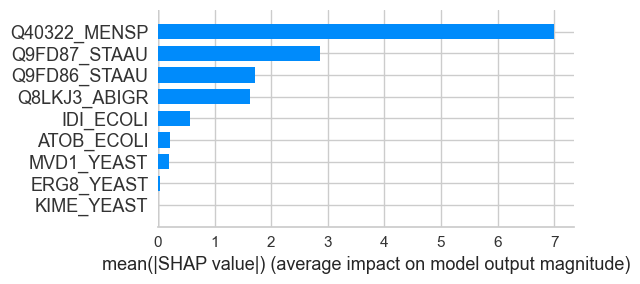

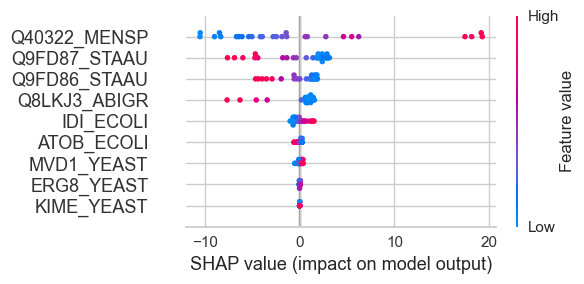

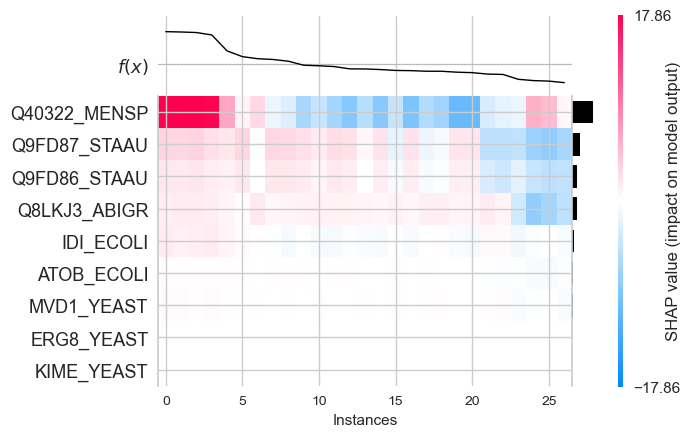

In [57]:
import shap

def pdplot(X: np.array, col: str, model: object, ice: bool=False):
    shap.plots.partial_dependence(col, model.predict, X, ice=ice, model_expected_value=True, feature_expected_value=True, show=True)
    
def shap_scatter(feature: str, color=None):
    if color:
        shap.plots.scatter(shap_values[:, feature], color=shap_values[:, color])
    else:
        shap.plots.scatter(shap_values[:, feature])

    
explainer = shap.Explainer(final_model.predict, df_A[INPUT_VARS])
shap_values = explainer(df_A[INPUT_VARS])
shap.summary_plot(shap_values, df_A[INPUT_VARS], plot_type="bar", plot_size=(6, 3))
shap.summary_plot(shap_values, df_A[INPUT_VARS], plot_type="dot", plot_size=(6, 3))
shap.plots.heatmap(shap_values, instance_order=shap_values.sum(1), plot_width=6)

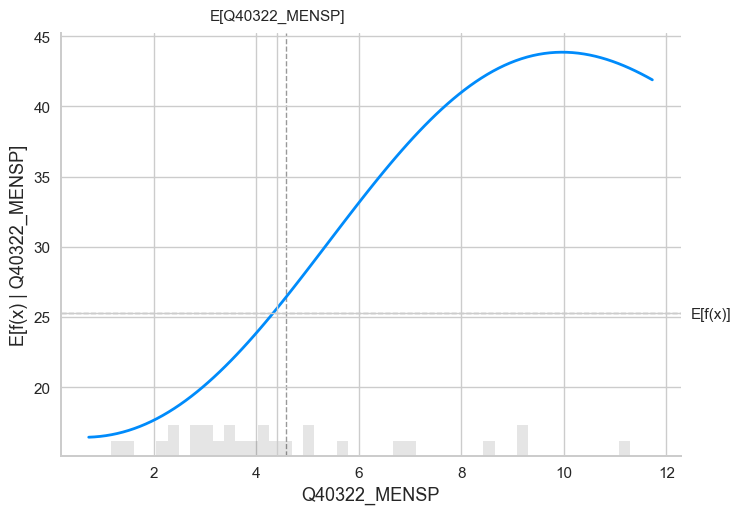

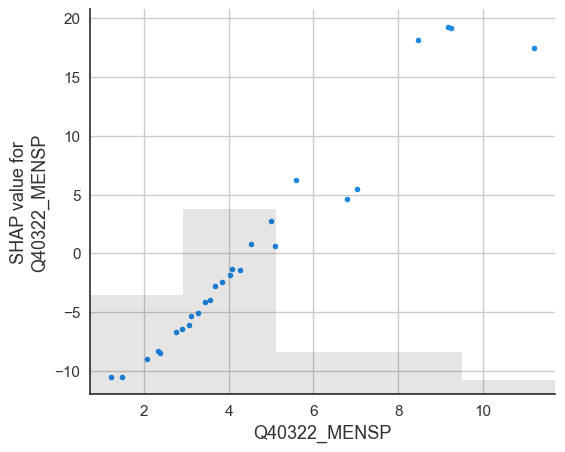

In [82]:
feature = 'Q40322_MENSP'
pdplot(df_A[INPUT_VARS], feature, final_model, ice=False)
shap_scatter(feature)

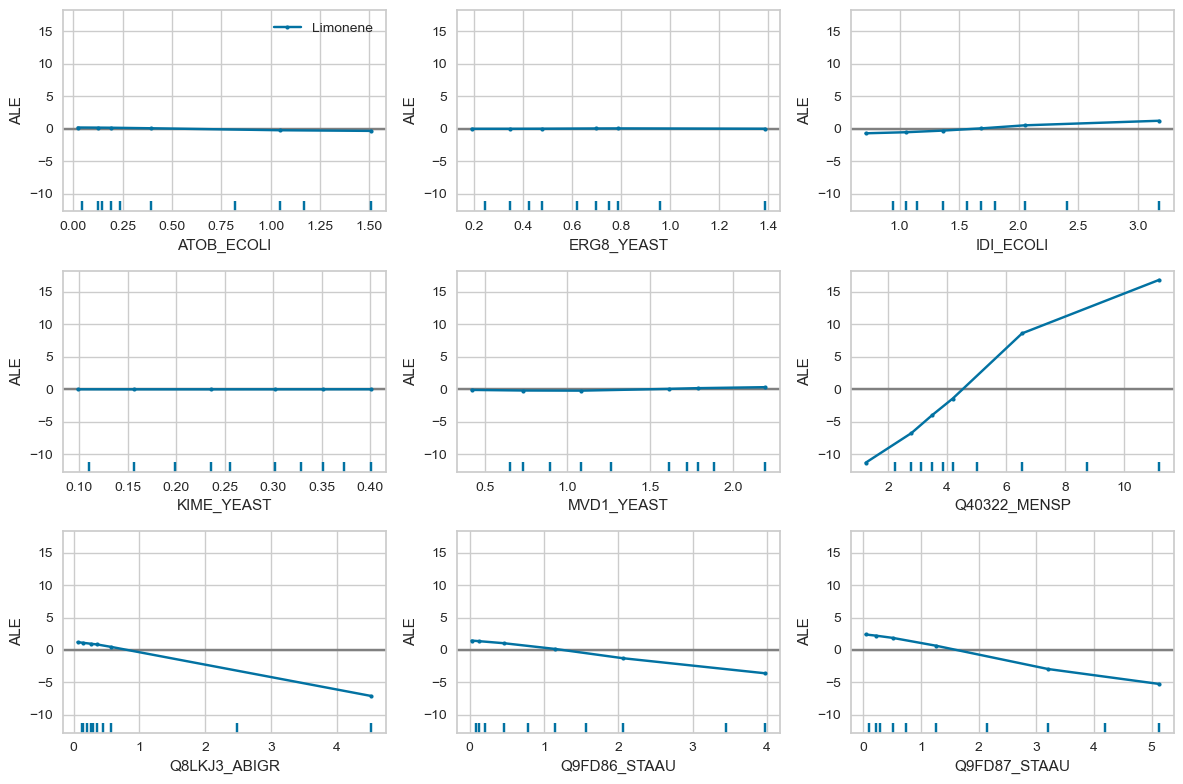

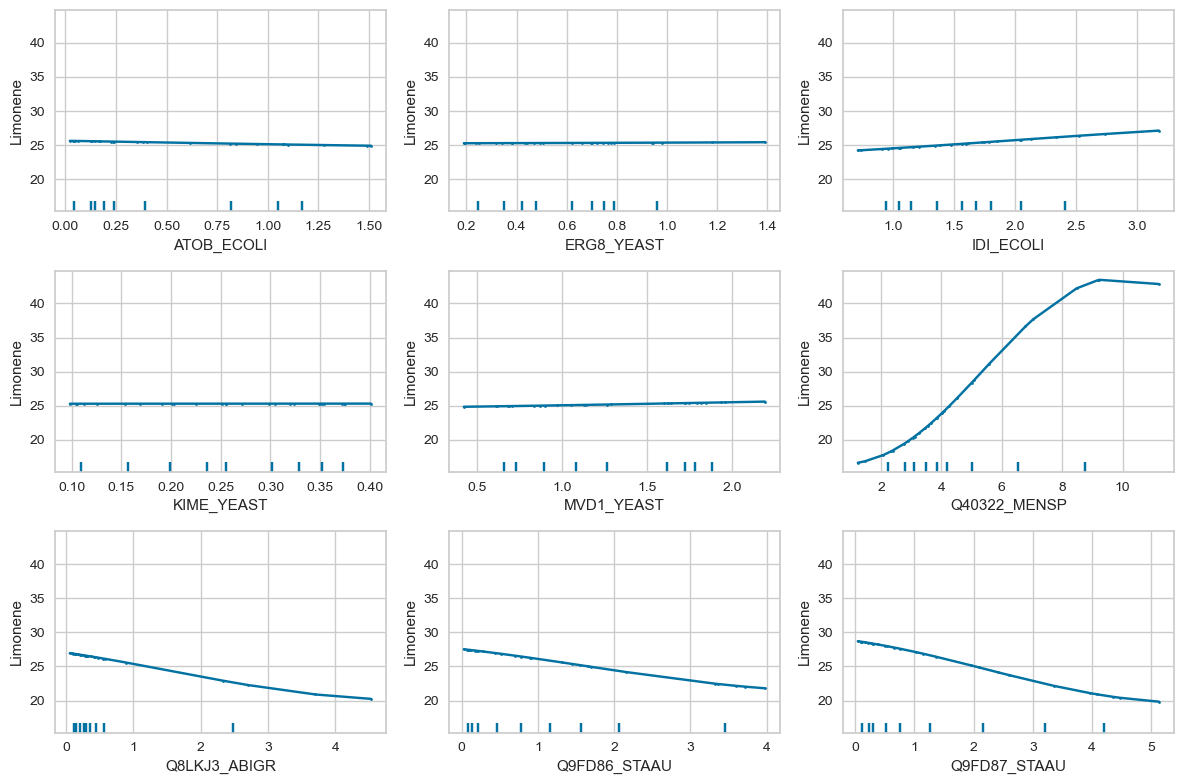

In [84]:
from alibi.explainers import ALE, plot_ale
from alibi.explainers import PartialDependence, plot_pd
import matplotlib.pyplot as plt

ale = ALE(final_model.predict, feature_names=INPUT_VARS, target_names=RESPONSE_VARS)
exp = ale.explain(X_train.values)
plot_ale(exp, fig_kw={'figwidth': 12, 'figheight': 8})
plt.show()

pdp = PartialDependence(predictor=final_model.predict, feature_names=INPUT_VARS, target_names=RESPONSE_VARS)
exp = pdp.explain(X_train.values)
plot_pd(exp, fig_kw={'figwidth': 12, 'figheight': 8})
plt.show()

#### Sampling

In [ ]:
bounds

Create new `sampling bounds`, to generate/recommend new strain designs.

In [ ]:
sampling_bounds = pd.DataFrame(columns=bounds.columns, index=bounds.index)

sampling_bounds['Q40322_MENSP'].loc['min'] = 11
sampling_bounds['Q40322_MENSP'].loc['max'] = bounds['Q40322_MENSP'].loc['max']

sampling_bounds['ATOB_ECOLI'].loc['min'] = 1
sampling_bounds['ATOB_ECOLI'].loc['max'] = bounds['ATOB_ECOLI'].loc['max']

sampling_bounds['Q9FD87_STAAU'].loc['min'] = bounds['Q9FD87_STAAU'].loc['min']
sampling_bounds['Q9FD87_STAAU'].loc['max'] = 1.0

sampling_bounds['Q8LKJ3_ABIGR'].loc['min'] = bounds['Q8LKJ3_ABIGR'].loc['min']
sampling_bounds['Q8LKJ3_ABIGR'].loc['max'] = 1.0

sampling_bounds['Q9FD86_STAAU'].loc['min'] = bounds['Q9FD86_STAAU'].loc['min']
sampling_bounds['Q9FD86_STAAU'].loc['max'] = 0.7

sampling_bounds['MVD1_YEAST'].loc['min'] = 0.5
sampling_bounds['MVD1_YEAST'].loc['max'] = bounds['MVD1_YEAST'].loc['max']

sampling_bounds['ERG8_YEAST'].loc['min'] = bounds['ERG8_YEAST'].loc['min']
sampling_bounds['ERG8_YEAST'].loc['max'] = 0.6

sampling_bounds['KIME_YEAST'].loc['min'] = 0.2
sampling_bounds['KIME_YEAST'].loc['max'] = bounds['KIME_YEAST'].loc['max']

sampling_bounds['IDI_ECOLI'].loc['min'] = 2.5
sampling_bounds['IDI_ECOLI'].loc['max'] = bounds['IDI_ECOLI'].loc['max']

# Draw samples fiven the above bounds
from scipy.stats import qmc

sampler = qmc.LatinHypercube(d=len(INPUT_VARS))
sample = sampler.random(10000)
LB = sampling_bounds.T['min'].values.tolist()
UB = sampling_bounds.T['max'].values.tolist()

sample_df = pd.DataFrame(qmc.scale(sample, LB, UB), columns=INPUT_VARS)
sample_df["pred"] = grid_search.best_estimator_.predict(sample_df)
sample_df.drop_duplicates(inplace=True)
sample_df.sort_values("pred", ascending=False, inplace=True)
sample_df.head(10)

# PCA

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca.fit(df_A[INPUT_VARS])
trans_df_A = pca.transform(df_A[INPUT_VARS])
trans_df_B = pca.transform(df_B[INPUT_VARS])
trans_rec  = pca.transform(sample_df[INPUT_VARS][:3])

# Plot
plt.scatter(trans_df_A[:,0], trans_df_A[:,1], label='DBTL_A')
plt.scatter(trans_df_B[:,0], trans_df_B[:,1], label='DBTL_B')
plt.scatter(trans_rec[:,0], trans_rec[:,1], label='REC')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Scatter Plot')
plt.legend()
plt.show()

In [ ]:
# import all 4 sdv models under the single table scenario
from sdv.single_table import GaussianCopulaSynthesizer
from sdv.metadata import SingleTableMetadata

metadata = SingleTableMetadata()
metadata.detect_from_dataframe(df_A.drop('Limonene', axis=1))

model_Gaussian = GaussianCopulaSynthesizer(metadata)
model_Gaussian.fit(df_A.drop('Limonene', axis=1))
synthetic_data = model_Gaussian.sample(1000)
synthetic_data['Limonene'] = grid_search.best_estimator_.predict(synthetic_data)
synthetic_data.sort_values(by='Limonene', ascending=False, inplace=True)
synthetic_data